In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# XAI libraries
from lime.lime_image import LimeImageExplainer
import shap
from alibi.explainers import AnchorImage
import skimage.segmentation as seg

print("Imports successful.")


Imports successful.


In [2]:
# Load MNIST
(mnist_X_train, mnist_y_train), (mnist_X_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()

# Normalize & reshape
mnist_X_train = mnist_X_train.astype('float32')/255.0
mnist_X_test  = mnist_X_test.astype('float32')/255.0
mnist_X_train = np.expand_dims(mnist_X_train, -1)
mnist_X_test  = np.expand_dims(mnist_X_test, -1)

# One-hot labels
mnist_y_train_cat = to_categorical(mnist_y_train, 10)
mnist_y_test_cat  = to_categorical(mnist_y_test, 10)

print("Train:", mnist_X_train.shape, mnist_y_train_cat.shape)
print("Test: ", mnist_X_test.shape,  mnist_y_test_cat.shape)

Train: (60000, 28, 28, 1) (60000, 10)
Test:  (10000, 28, 28, 1) (10000, 10)


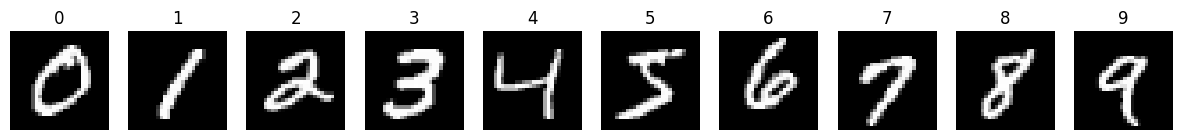

In [3]:
plt.figure(figsize=(15, 10))

# MNIST
for i in range(10):
    plt.subplot(3, 10, i+1)
    plt.imshow(mnist_X_train[mnist_y_train == i][0].reshape(28, 28), cmap='gray')
    plt.title(i)
    plt.axis('off')

E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.8588 - loss: 0.4870 - val_accuracy: 0.9800 - val_loss: 0.0662
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.9790 - loss: 0.0643 - val_accuracy: 0.9858 - val_loss: 0.0461
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9863 - loss: 0.0436 - val_accuracy: 0.9853 - val_loss: 0.0534
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9904 - loss: 0.0315 - val_accuracy: 0.9872 - val_loss: 0.0411
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9926 - loss: 0.0231 - val_accuracy: 0.9900 - val_loss: 0.0335
Test accuracy: 0.9896


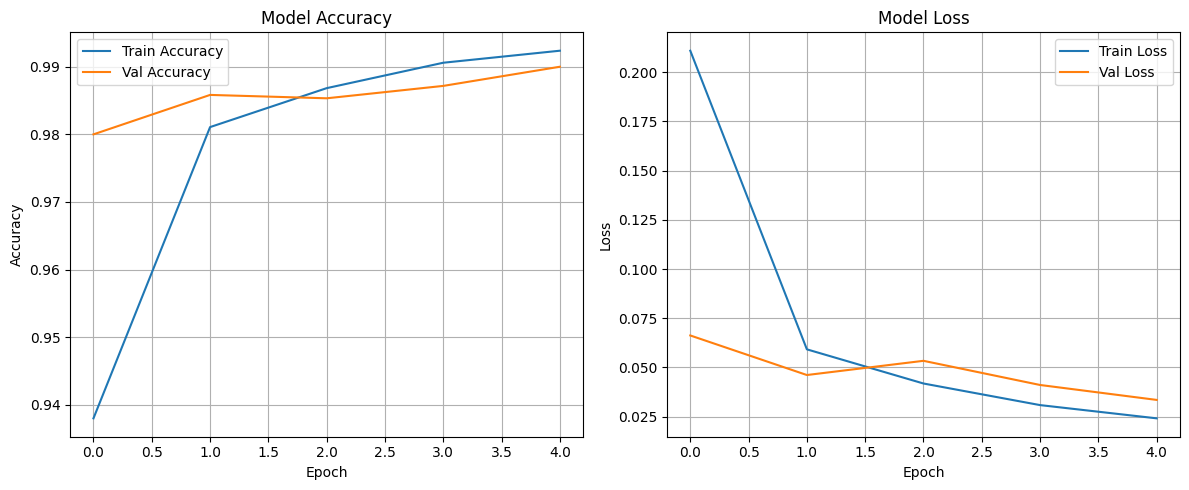

In [25]:
def cnn_predict(x):
    # If input is RGB (LIME case), convert to grayscale
    if x.shape[-1] == 3:
        x = np.mean(x, axis=-1, keepdims=True)  # average across RGB channels
    return cnn.predict(x)


def build_mnist_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=mnist_X_train.shape[1:]),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn = build_mnist_cnn()
history = cnn.fit(
    mnist_X_train, mnist_y_train_cat,
    epochs=5, batch_size=128,
    validation_split=0.1, verbose=1
)
loss, acc = cnn.evaluate(mnist_X_test, mnist_y_test_cat, verbose=0)
print(f"Test accuracy: {acc:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],    label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],    label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### LIME Image Explainer

We segment the image into superpixels and see which regions most influence the CNN's prediction.


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

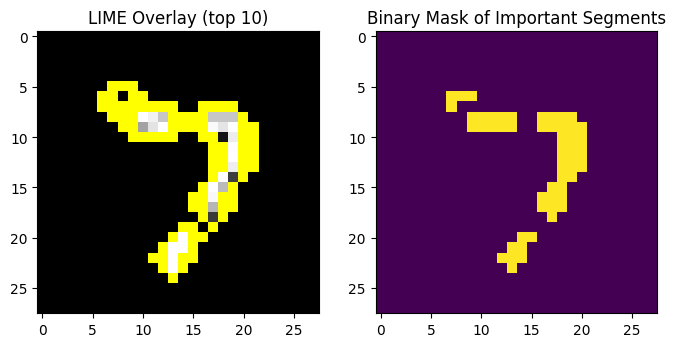

In [9]:
lime_exp = LimeImageExplainer()

from skimage.segmentation import slic, mark_boundaries

# define a slic‑based segmentation function
def segmentation_fn(img):
    # img is H×W or H×W×3, slic expects H×W×C
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)
    return slic(img, n_segments=200, compactness=10, sigma=1)

# explain with more samples & features
explanation = lime_exp.explain_instance(
    image=mnist_X_test[idx].squeeze(),   # still H×W
    classifier_fn=cnn_predict,           # our wrapper that handles channels
    top_labels=1,                        # focus on the top prediction
    hide_color=0,                        # hide segments with black
    num_samples=2000,                    # more perturbed samples
    segmentation_fn=segmentation_fn      # our new slic fn
)

# extract a denser mask
label = explanation.top_labels[0]
temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,    # only show positively contributing segments
    num_features=10,       # show top‑10 segments
    hide_rest=True         # hide everything else
)

# visualize overlay and raw mask
fig, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].imshow(mark_boundaries(temp, mask))
axes[0].set_title("LIME Overlay (top 10)")
axes[1].imshow(mask, cmap='viridis')
axes[1].set_title("Binary Mask of Important Segments")
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━

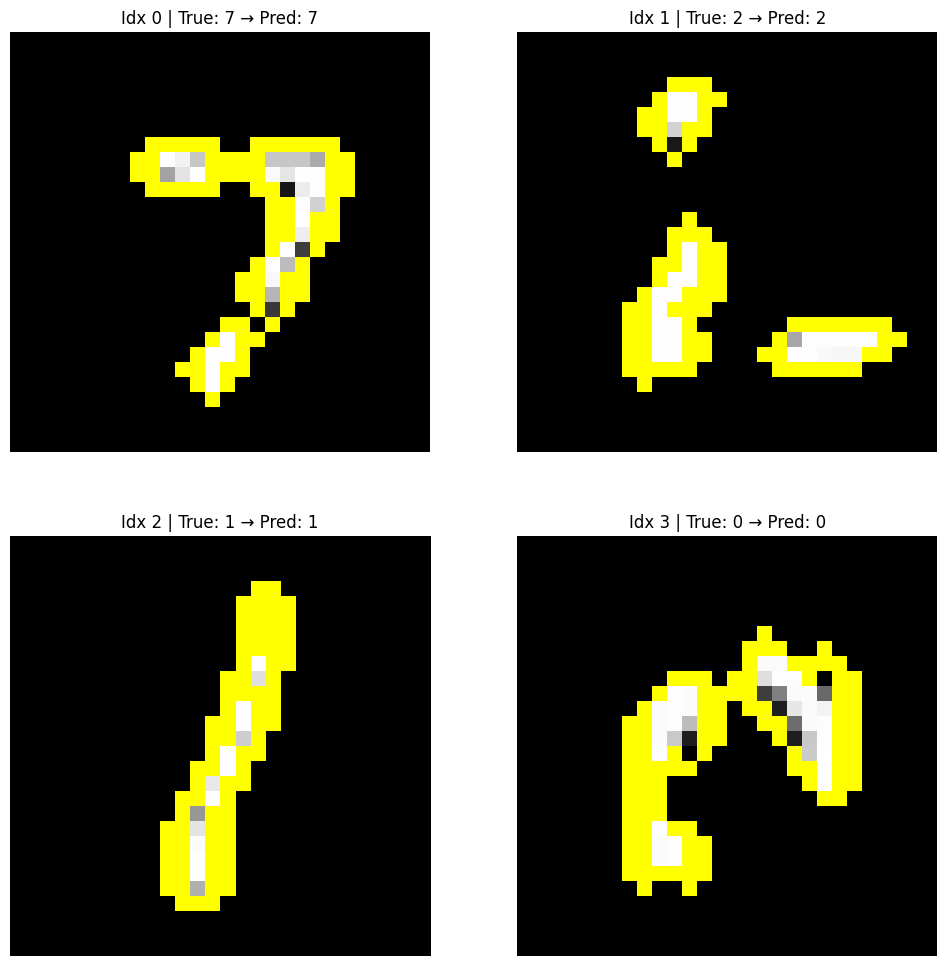

In [10]:
# Choose the test image indices you want to explain
indices = [0, 1, 2, 3]  # e.g. first four test images

# Prepare the grid
n = len(indices)
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

# Loop through each selected index
for ax, idx in zip(axes.flatten(), indices):
    # Run LIME on this image
    explanation = lime_exp.explain_instance(
        image=mnist_X_test[idx].squeeze(),   # H×W grayscale
        classifier_fn=cnn_predict,           # wrapper that handles RGB→gray
        top_labels=1,
        hide_color=0,
        num_samples=2000,
        segmentation_fn=segmentation_fn      # our SLIC fn
    )
    label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        label,
        positive_only=True,
        num_features=10,
        hide_rest=True
    )
    # Display overlay
    ax.imshow(mark_boundaries(temp, mask))
    true_label = mnist_y_test[idx]
    pred_label = cnn.predict(mnist_X_test[idx:idx+1]).argmax()
    ax.set_title(f"Idx {idx} | True: {true_label} → Pred: {pred_label}")
    ax.axis('off')

plt.show()

### SHAP DeepExplainer

We use a small background set to approximate Shapley values.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


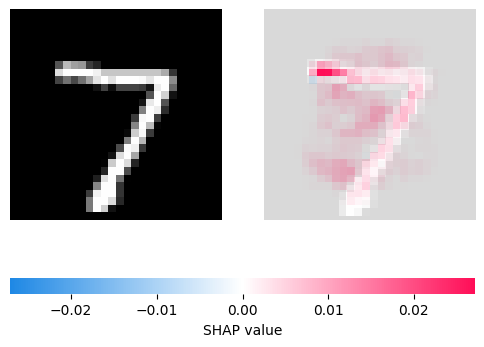

In [32]:
# Select background and test samples
bg = mnist_X_train[np.random.choice(len(mnist_X_train), 100, replace=False)]

# pick your test batch and predictions
test = mnist_X_test[:5]
preds = np.argmax(cnn.predict(test), axis=1)  # shape (5,)
explainer_shap = shap.KernelExplainer(cnn_predict, bg[:50])

test = mnist_X_test[:5]
preds = np.argmax(cnn.predict(test), axis=1)

# choose a sample index
i   = 0
cls = preds[i]     # e.g. 7

# extract the SHAP map for that sample & class
#    shape will be (1, 28, 28, 1)
sv = shap_vals[i : i+1,    # sample i
               :, :, :,    # all pixels & channel
               cls]        # predicted class

# pixel values for the same sample
pv = test[i : i+1]         # shape (1, 28, 28, 1)

# plot
shap.image_plot(sv, pv)

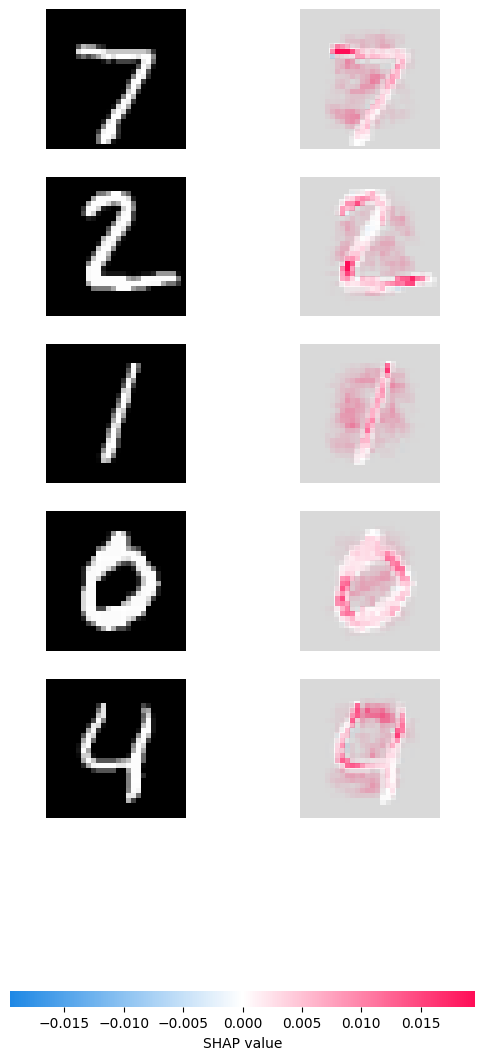

In [15]:
# build an array of SHAP maps, one per sample
svs = np.stack([
    shap_vals[j, :, :, :, preds[j]]    # for sample j, class preds[j]
    for j in range(len(test))
], axis=0)  # shape (5,28,28,1)

# now plot all
shap.image_plot(svs, test)

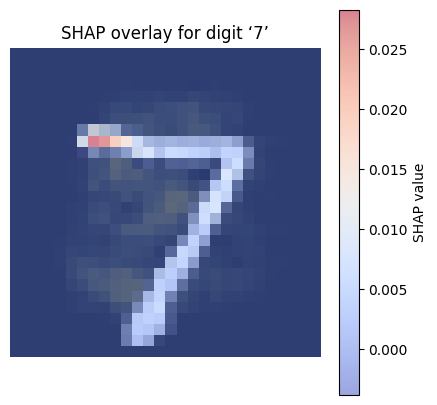

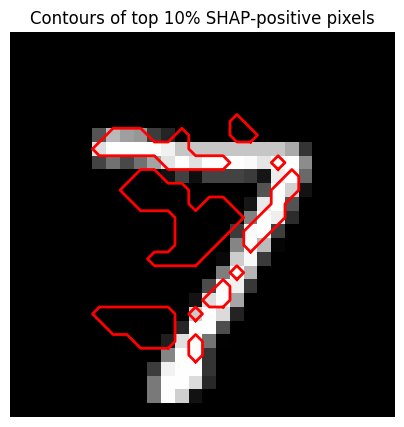

In [16]:
import matplotlib.pyplot as plt
from skimage import measure

# pick sample
i   = 0
cls = preds[i]                   # predicted class index
orig = test[i].squeeze()         # 28×28 grayscale

# extract the raw SHAP map for sample i, class cls
shap_map = shap_vals[i, :, :, 0, cls]  # shape (28,28)

# Overlay heatmap on the original
plt.figure(figsize=(5,5))
plt.imshow(orig, cmap='gray', interpolation='nearest')
plt.imshow(shap_map, cmap='coolwarm', alpha=0.5)  
plt.title(f"SHAP overlay for digit ‘{cls}’")
plt.colorbar(label="SHAP value")
plt.axis('off')
plt.show()

# Threshold to get the top 10% most positive pixels
thresh = np.percentile(shap_map, 90)
mask   = shap_map >= thresh      # boolean mask of shape (28,28)

# Find contours on that mask
contours = measure.find_contours(mask, 0.5)

# Plot original + contour lines
plt.figure(figsize=(5,5))
plt.imshow(orig, cmap='gray', interpolation='nearest')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
plt.title("Contours of top 10% SHAP‑positive pixels")
plt.axis('off')
plt.show()

### Gradient‑based Saliency

We compute ∂(logit_of_predicted_class)/∂input_pixels.


E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 28, 28, 1))
  warnings.warn(msg)


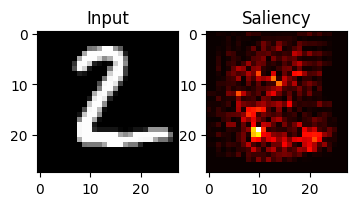

In [17]:
# Wrap model to get logits
layer = cnn.layers[-1]
logits_model = models.Model(cnn.inputs, layer.input)  # pre-softmax

# Compute saliency for one sample
img = tf.convert_to_tensor(mnist_X_test[1:2])
with tf.GradientTape() as tape:
    tape.watch(img)
    logits = logits_model(img)
    pred_index = tf.argmax(logits[0])
    score = logits[0, pred_index]

grad = tape.gradient(score, img)[0].numpy().squeeze()

# Visualize
plt.figure(figsize=(4,2))
plt.subplot(1,2,1); plt.title("Input"); plt.imshow(img[0].numpy().squeeze(), cmap='gray')
plt.subplot(1,2,2); plt.title("Saliency"); plt.imshow(np.abs(grad), cmap='hot')
plt.show()


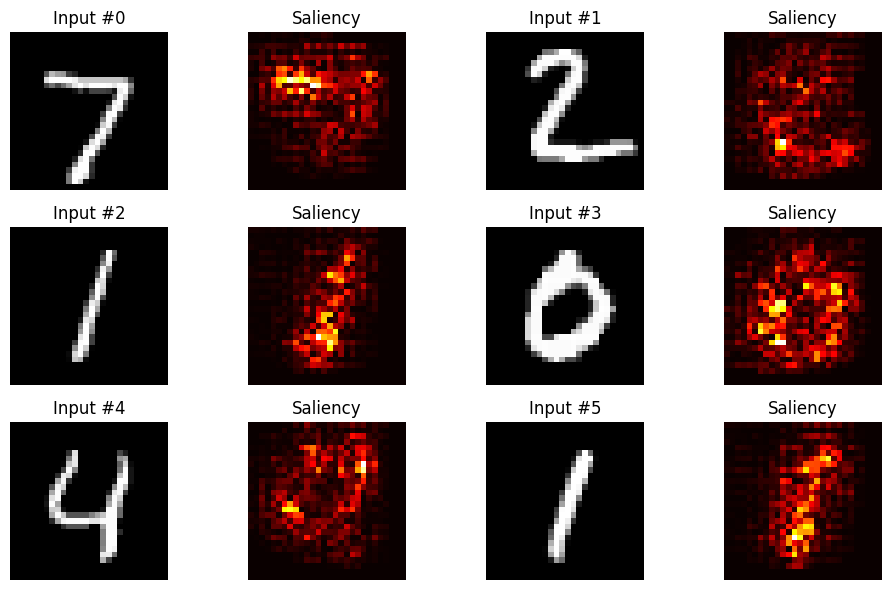

In [18]:
layer = cnn.layers[-1]
logits_model = models.Model(cnn.inputs, layer.input)  # outputs pre-softmax logits

# --- Pick N samples to visualize ---
N = 6
samples = mnist_X_test[:N]

# --- Create figure for grid ---
plt.figure(figsize=(10, 6))  # Adjust size as needed

for i in range(N):
    img = tf.convert_to_tensor(samples[i:i+1])  # shape (1, 28, 28, 1)

    # --- Compute saliency ---
    with tf.GradientTape() as tape:
        tape.watch(img)
        logits = logits_model(img)
        pred_index = tf.argmax(logits[0])
        score = logits[0, pred_index]

    grad = tape.gradient(score, img)[0].numpy().squeeze()  # shape (28, 28)

    # --- Plot original image ---
    plt.subplot(3, 4, 2*i + 1)
    plt.imshow(img[0].numpy().squeeze(), cmap='gray')
    plt.title(f"Input #{i}")
    plt.axis('off')

    # --- Plot saliency map (absolute gradient) ---
    plt.subplot(3, 4, 2*i + 2)
    plt.imshow(np.abs(grad), cmap='hot')
    plt.title("Saliency")
    plt.axis('off')

plt.tight_layout()
plt.show()

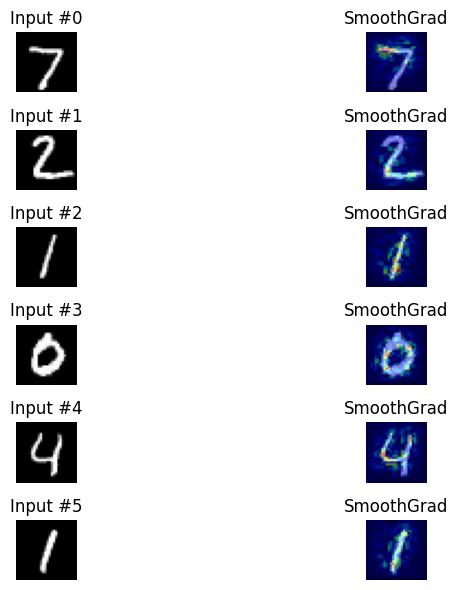

In [19]:
def smooth_grad(model, img, 
                stdev_spread=0.15, 
                n_samples=50, 
                magnitude=True):
    """
    Compute SmoothGrad saliency map for a single image.
      - model: tf.keras.Model returning pre-softmax logits
      - img:    single image tensor, shape (1,H,W,1), values in [0,1]
      - stdev_spread: noise stdev as fraction of (max-min) of img
      - n_samples: number of noisy samples to average
      - magnitude: if True, take abs of gradients
    Returns:
      saliency map, shape (H,W)
    """
    img = tf.cast(img, tf.float32)
    stdev = stdev_spread * (tf.reduce_max(img) - tf.reduce_min(img))
    
    grads_accum = tf.zeros_like(img)
    for _ in range(n_samples):
        noise = tf.random.normal(shape=tf.shape(img), stddev=stdev)
        noisy_img = img + noise
        with tf.GradientTape() as tape:
            tape.watch(noisy_img)
            logits = model(noisy_img)                 # shape (1, num_classes)
            pred = tf.argmax(logits[0])              # scalar
            score = logits[0, pred]
        grads = tape.gradient(score, noisy_img)      # shape (1,H,W,1)
        grads_accum += grads
    
    avg_grads = grads_accum / tf.cast(n_samples, tf.float32)
    sal = tf.abs(avg_grads) if magnitude else avg_grads
    sal = tf.squeeze(sal).numpy()                  # (H,W)
    # normalize to [0,1]
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal

# --- Example plotting for N samples ---
N = 6
samples = mnist_X_test[:N]  # shape (N,28,28,1)

# Build a logits model if you haven’t already:
last_conv = cnn.layers[-1]            # e.g. the last conv or FC before softmax
logits_model = tf.keras.Model(cnn.inputs, last_conv.input)

plt.figure(figsize=(10, 6))
for i in range(N):
    img = samples[i:i+1]              # (1,28,28,1)
    sg = smooth_grad(logits_model, img, n_samples=100)

    # show original
    plt.subplot(N, 2, 2*i+1)
    plt.imshow(img[0,:,:,0], cmap='gray')
    plt.title(f"Input #{i}")
    plt.axis('off')

    # show SmoothGrad overlay
    plt.subplot(N, 2, 2*i+2)
    plt.imshow(img[0,:,:,0], cmap='gray')
    plt.imshow(sg, cmap='jet', alpha=0.5)  # jet heatmap on top
    plt.title("SmoothGrad")
    plt.axis('off')

plt.tight_layout()
plt.show()

### AnchorImage Explainer (from Alibi)

Anchors find “if these superpixels are present, the prediction won’t change.”


In [103]:
from alibi.utils.visualize import plot_anchors

ModuleNotFoundError: No module named 'alibi.utils.visualize'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\alibi\explainers\anchors\anchor_image.py:45: RuntimeWarning: invalid value encountered in divide
  img_std = (image - img_min) / (img_max - img_min)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


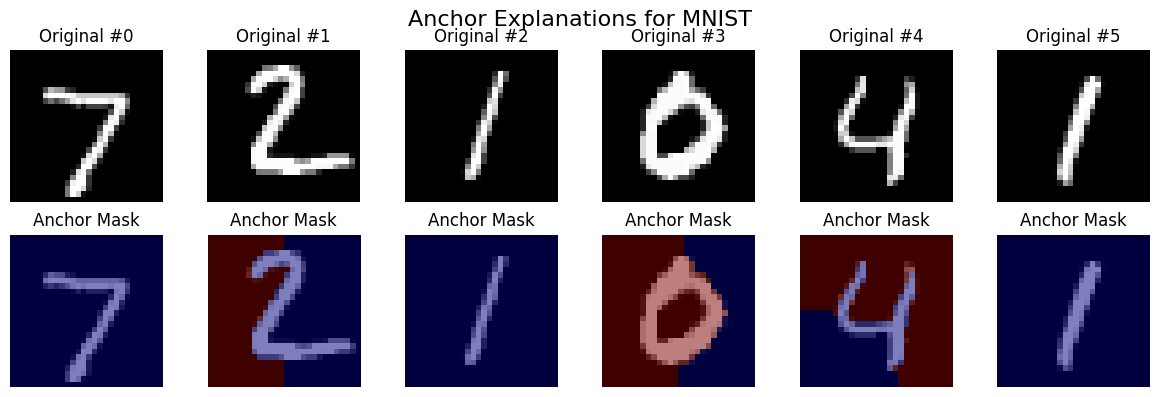

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from alibi.explainers import AnchorImage
from skimage import segmentation as seg

# Fix: Define segmentation function that converts grayscale to RGB
seg_fn = lambda x: seg.quickshift(np.repeat(x, 3, axis=-1), kernel_size=4, max_dist=200, ratio=0.2)

# Initialize explainer
anc_exp = AnchorImage(
    predictor=cnn_predict,
    image_shape=mnist_X_test.shape[1:],  # (28, 28, 1)
    segmentation_fn=seg_fn
)

# Number of images to visualize
n_images = 6
rows, cols = 2, n_images

# Create plot
fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
fig.suptitle('Anchor Explanations for MNIST', fontsize=16)

for i in range(n_images):
    img = mnist_X_test[i]

    # Get anchor explanation
    explanation = anc_exp.explain(img, threshold=0.95, p_sample=0.5)
    segments = explanation.segments
    anchor = explanation.anchor

    # Build anchor mask
    mask = np.zeros_like(segments)
    for a in anchor:
        mask[segments == a] = 1

    # Plot original and mask side-by-side
    axs[0, i].imshow(img.squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f"Original #{i}")

    axs[1, i].imshow(img.squeeze(), cmap='gray')
    axs[1, i].imshow(mask, cmap='jet', alpha=0.5)
    axs[1, i].axis('off')
    axs[1, i].set_title("Anchor Mask")

plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Make room for suptitle
plt.show()


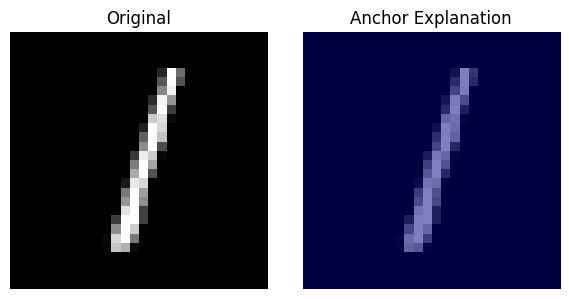

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Segment image (internally done by explainer, but you can access it)
segments = explanation.segments
anchor = explanation.anchor
img = mnist_X_test[2].squeeze()

# Create mask of anchor superpixels
mask = np.zeros_like(segments)
for a in anchor:
    mask[segments == a] = 1

# Plot original and anchor mask
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(img, cmap='gray')
axs[1].imshow(mask, cmap='jet', alpha=0.5)
axs[1].set_title('Anchor Explanation')
axs[1].axis('off')

plt.tight_layout()
plt.show()


## Benchmark Metrics
#### Define Metrics (Code + Markdown)

**Fidelity:** How well the explainer’s top‑k features predict the model’s output.  
**Stability:** Consistency of explanations under small input noise.  
**Sparsity:** Number of features used in the explanation.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [26]:
# %% [code]
def fidelity_metric(model, img, explanation_mask, drop_value=0.0):
    """
    Fidelity metric: Drop important pixels and measure the change in prediction probability.
    - model: trained model
    - img: original image (numpy array)
    - explanation_mask: binary mask where important pixels are 1.
    - drop_value: value to replace dropped pixels (default 0.0).
    
    Returns the difference in probability for the predicted class.
    """
    img = img.copy()
    pred_orig = model.predict(img[np.newaxis, ...]).squeeze()
    pred_class = np.argmax(pred_orig)
    
    # Create a perturbed image by dropping pixels in the explanation region
    perturbed = img.copy()
    perturbed[explanation_mask==1] = drop_value
    
    pred_perturbed = model.predict(perturbed[np.newaxis, ...]).squeeze()
    
    # Fidelity as the drop in predicted probability for the predicted class
    fidelity = pred_orig[pred_class] - pred_perturbed[pred_class]
    return fidelity

def stability_metric(explanation_func, img, perturb_std=0.05, n_samples=5):
    """
    Stability metric: Compute explanation for slightly perturbed images and measure variance.
    - explanation_func: a function that takes an image and returns an explanation mask (numpy array)
    - img: original image
    - perturb_std: standard deviation for noise
    - n_samples: number of perturbations
    
    Returns the average pairwise difference between explanation masks.
    """
    explanations = []
    for _ in range(n_samples):
        noise = np.random.normal(0, perturb_std, img.shape)
        perturbed_img = img + noise
        perturbed_img = np.clip(perturbed_img, 0, 1)
        exp_mask = explanation_func(perturbed_img)
        explanations.append(exp_mask)
    
    # Compute pairwise differences (using L1 norm normalized by image size)
    diffs = []
    for i in range(len(explanations)):
        for j in range(i+1, len(explanations)):
            diff = np.sum(np.abs(explanations[i]-explanations[j])) / explanations[i].size
            diffs.append(diff)
    return np.mean(diffs)

def sparsity_metric(explanation_mask):
    """
    Sparsity metric: The fraction of pixels not highlighted.
    Lower values indicate denser explanations.
    """
    return np.sum(explanation_mask==0) / explanation_mask.size

# Using LIME explanation mask as binary mask (already computed 'mask' variable from LIME explanation)
# For demonstration, we pick one image from the test set and compute the metrics.

# get an explanation mask from LIME for image index 0
explanation = lime_exp.explain_instance(
    image=mnist_X_test[0].squeeze(),
    classifier_fn=cnn_predict,
    top_labels=1,
    hide_color=0,
    num_samples=2000,
    segmentation_fn=segmentation_fn
)
label = explanation.top_labels[0]
_, lime_mask = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=10,
    hide_rest=True
)

# binarize the mask
lime_mask_bin = (lime_mask > 0).astype(np.uint8)

fidelity_lime = fidelity_metric(cnn, mnist_X_test[0], lime_mask_bin)
# For stability, define an explanation function that always returns the same mask from LIME
def lime_explanation_func(img):
    exp = lime_exp.explain_instance(
        image=img.squeeze(),
        classifier_fn=cnn_predict,
        top_labels=1,
        hide_color=0,
        num_samples=2000,
        segmentation_fn=segmentation_fn
    )
    _, mask_tmp = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    return (mask_tmp > 0).astype(np.uint8)

stability_lime = stability_metric(lime_explanation_func, mnist_X_test[0])
sparsity_lime = sparsity_metric(lime_mask_bin)

print(f"LIME Fidelity: {fidelity_lime:.4f}")
print(f"LIME Stability: {stability_lime:.4f}")
print(f"LIME Sparsity: {sparsity_lime:.4f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [49]:
def cnn_predict_flat(x):
    # x is of shape where features = 28*28 (or 28*28*1)
    x_reshaped = x.reshape(-1, 28, 28, 1)
    return cnn.predict(x_reshaped)

# preparing a flattened background dataset from the training images.
bg_flat = mnist_X_train.reshape(mnist_X_train.shape[0], -1)
bg_indices = np.random.choice(bg_flat.shape[0], 100, replace=False)
bg_subset = bg_flat[bg_indices]

# initializing the SHAP KernelExplainer with the flattened predictor and background.
explainer_shap = shap.KernelExplainer(cnn_predict_flat, bg_subset[:50])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 


In [45]:
def get_shap_explanation_mask(img, nsamples=100):
    """
    Computing SHAP explanation mask for the given image.
    Handling SHAP output shape (784, 10) and extracts the predicted class column.
    """
    img_flat = img.reshape(1, -1)
    shap_vals = explainer_shap.shap_values(img_flat, nsamples=nsamples)
    pred_class = np.argmax(cnn.predict(img[np.newaxis, ...]).squeeze())

    # --- safely handle known output format ---
    shap_array = None

    # Case: SHAP returns a single ndarray (e.g., shape (784, 10))
    if isinstance(shap_vals, np.ndarray):
        if shap_vals.shape == (784, 10):
            shap_array = shap_vals[:, pred_class]
        elif shap_vals.shape == (1, 784, 10):
            shap_array = shap_vals[0, :, pred_class]
        elif shap_vals.shape == (10, 784):
            shap_array = shap_vals[pred_class, :]
        else:
            raise ValueError(f"Unexpected SHAP array shape: {shap_vals.shape}")

    # Case: SHAP returns a list of 10 arrays (one per class)
    elif isinstance(shap_vals, list) and len(shap_vals) == 10:
        shap_array = shap_vals[pred_class].squeeze()

    else:
        raise ValueError(f"Unrecognized SHAP output format or shape: {type(shap_vals)} with shape {np.shape(shap_vals)}")

    # --- reshape to (28, 28) ---
    try:
        shap_map = np.abs(shap_array.reshape(28, 28))
    except Exception as e:
        print("Error in reshaping SHAP values:", e)
        print("shap_array shape:", shap_array.shape)
        raise e

    # threshold at 90th percentile
    thresh = np.percentile(shap_map, 90)
    mask = (shap_map >= thresh).astype(np.uint8)
    return mask

# Compute SHAP metrics
shap_mask = get_shap_explanation_mask(mnist_X_test[0])
fidelity_shap = fidelity_metric(cnn, mnist_X_test[0], shap_mask)
stability_shap = stability_metric(get_shap_explanation_mask, mnist_X_test[0])
sparsity_shap = sparsity_metric(shap_mask)

print(f"SHAP Fidelity: {fidelity_shap:.4f}")
print(f"SHAP Stability: {stability_shap:.4f}")
print(f"SHAP Sparsity: {sparsity_shap:.4f}")


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.390e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.201e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=6.679e-03, with an active se

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e. alpha=1.526e-02, with an active set of 2 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=5.361e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=5.291e-03, with an active se

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.830e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=3.060e-02, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=2.192e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.994e-02, with an active se

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
SHAP Fidelity: 0.8962
SHAP Stability: 0.0000
SHAP Sparsity: 0.0000


In [28]:
# %% [code]
def get_anchor_explanation_mask(img):
    """
    Getting a binary mask from the Anchor explanation for a given image.
    Using the alibi AnchorImage explainer to generate the explanation, then creating
    a mask by setting regions corresponding to the anchor segments to 1.
    """
    explanation = anc_exp.explain(img, threshold=0.95, p_sample=0.5)
    segments = explanation.segments
    anchor = explanation.anchor  # List of segment indices that form the anchor.
    
    mask = np.zeros_like(segments)
    for a in anchor:
        mask[segments == a] = 1
    return mask.astype(np.uint8)

# Compute Anchors explanation metrics for the first test image.
anchor_mask = get_anchor_explanation_mask(mnist_X_test[0])
fidelity_anchor = fidelity_metric(cnn, mnist_X_test[0], anchor_mask)
stability_anchor = stability_metric(get_anchor_explanation_mask, mnist_X_test[0])
sparsity_anchor = sparsity_metric(anchor_mask)

print(f"Anchors Fidelity: {fidelity_anchor:.4f}")
print(f"Anchors Stability: {stability_anchor:.4f}")
print(f"Anchors Sparsity: {sparsity_anchor:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


E:\Source Codes\AIML\final_year_paper\myenv\Lib\site-packages\alibi\explainers\anchors\anchor_image.py:45: RuntimeWarning: invalid value encountered in divide
  img_std = (image - img_min) / (img_max - img_min)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Anchors Fidelity: 0.8962
Anchors Stability: 0.0000
Anchors Sparsity: 0.0000


In [29]:
def get_saliency_explanation_mask(img):
    """
    Computing the saliency map as the gradient of the predicted class score with respect to the input.
    Then threshold the absolute gradient values at the 90th percentile to produce a binary mask.
    """
    img_tensor = tf.convert_to_tensor(img[np.newaxis, ...])
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        logits = cnn(img_tensor)
        pred_class = tf.argmax(logits[0])
        score = logits[0, pred_class]
    grad = tape.gradient(score, img_tensor).numpy().squeeze()
    saliency_map = np.abs(grad)
    thresh = np.percentile(saliency_map, 90)
    mask = (saliency_map >= thresh).astype(np.uint8)
    return mask

# Compute Saliency explanation metrics for the first test image.
saliency_mask = get_saliency_explanation_mask(mnist_X_test[0])
fidelity_saliency = fidelity_metric(cnn, mnist_X_test[0], saliency_mask)
stability_saliency = stability_metric(get_saliency_explanation_mask, mnist_X_test[0])
sparsity_saliency = sparsity_metric(saliency_mask)

print(f"Saliency Fidelity: {fidelity_saliency:.4f}")
print(f"Saliency Stability: {stability_saliency:.4f}")
print(f"Saliency Sparsity: {sparsity_saliency:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Saliency Fidelity: 0.0731
Saliency Stability: 9.9918
Saliency Sparsity: 0.8992


### Hybrid Explanation Approach

In [55]:
# %% [code]
def get_shap_explanation_mask(img, nsamples=100):
    """
    Get a SHAP explanation mask for a given image.
    """
    img_flat = img.reshape(1, -1)  # (1, 784)
    shap_vals_single = explainer_shap.shap_values(img_flat, nsamples=nsamples)

    pred_class = np.argmax(cnn.predict(img[np.newaxis, ...]).squeeze())

    # Case 1: SHAP returns a list of arrays (usual)
    if isinstance(shap_vals_single, list):
        shap_map_flat = np.abs(shap_vals_single[pred_class][0])  # (784,)
    
    # Case 2: SHAP returns a single array (1, 7840)
    elif isinstance(shap_vals_single, np.ndarray) and shap_vals_single.shape[1] == 7840:
        # Reshape to (10, 784), then select pred_class
        shap_all_classes = shap_vals_single.reshape(-1, 10, 784)[0]
        shap_map_flat = np.abs(shap_all_classes[pred_class])
    
    else:
        raise ValueError(f"Unexpected SHAP shape: {np.shape(shap_vals_single)}")

    shap_map = shap_map_flat.reshape(28, 28)
    thresh = np.percentile(shap_map, 99)
    mask = (shap_map >= thresh).astype(np.uint8)
    return mask

def get_lime_explanation_mask(img):
    """
    Get a binary LIME explanation mask.
    """
    exp = lime_exp.explain_instance(
        image=img.squeeze(),
        classifier_fn=cnn_predict,
        top_labels=1,
        hide_color=0,
        num_samples=2000,
        segmentation_fn=segmentation_fn
    )
    _, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
    return (mask > 0).astype(np.uint8)

def hybrid_explanation(img, weight_lime=0.5, weight_shap=0.5):
    """
    Combine LIME and SHAP explanations.
    """
    mask_lime = get_lime_explanation_mask(img)
    mask_shap = get_shap_explanation_mask(img)
    # Combine using weighted average and threshold at 0.5 to create binary mask.
    hybrid = weight_lime * mask_lime + weight_shap * mask_shap
    hybrid_mask = (hybrid >= 0.5).astype(np.uint8)
    return mask_lime, mask_shap, hybrid_mask

# Example for a test image
test_img = mnist_X_test[0]
mask_lime, mask_shap, mask_hybrid = hybrid_explanation(test_img, 0.5, 0.5)

# Plot the three explanation masks side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(test_img.squeeze(), cmap='gray')
axes[0].imshow(mask_lime, cmap='jet', alpha=0.5)
axes[0].set_title("LIME Mask")
axes[0].axis('off')

axes[1].imshow(test_img.squeeze(), cmap='gray')
axes[1].imshow(mask_shap, cmap='jet', alpha=0.5)
axes[1].set_title("SHAP Mask")
axes[1].axis('off')

axes[2].imshow(test_img.squeeze(), cmap='gray')
axes[2].imshow(mask_hybrid, cmap='jet', alpha=0.5)
axes[2].set_title("Hybrid Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("SHAP output shape:", np.shape(shap_vals_single))


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


ValueError: Unexpected SHAP shape: (1, 784, 10)

In [24]:
# sample subset
X_sub = mnist_X_test[:50]

methods = {
    'LIME': lime_map,
    'SHAP': shap_map,
    'Saliency': saliency_map,
    'Anchors': anchor_map
}

results = {}
for name, fn in methods.items():
    f = compute_fidelity(fn, X_sub, cnn)
    s = compute_stability(fn, X_sub, cnn)
    p = compute_sparsity(fn, X_sub)
    results[name] = (f, s, p)

df_metrics = pd.DataFrame(results, index=['Fidelity','Stability','Sparsity']).T
df_metrics


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

ValueError: operands could not be broadcast together with shapes (28,28,3) (28,28) 

**Interpretation:**  
- **High fidelity** ⇒ explainer pinpoints truly influential pixels.  
- **High stability** ⇒ robust to noise.  
- **Low sparsity** ⇒ uses few pixels (more interpretable).


In [ ]:
# tune alpha on validation subset
alphas = np.linspace(0,1,11)
best = (None, -np.inf)
for α in alphas:
    def hybrid_map(x):
        return α*lime_map(x) + (1-α)*shap_map(x)
    fid = compute_fidelity(hybrid_map, X_sub, cnn)
    if fid>best[1]:
        best = (α, fid)
print("Best α:", best[0], "with fidelity", best[1])


In [ ]:
# Visualize hybrid explanation for one sample
α = best[0]
hm = hybrid_map(mnist_X_test[5])
plt.imshow(np.abs(hm), cmap='hot'); plt.title(f"Hybrid Map (α={α:.1f})"); plt.show()
